## 千兆病理图像癌细胞转移检测
## Detecting Cancer Metastases on Gigapixel Pathology Images

In [1]:
ls

Detecting_Cancer_Metastases_on_Gigapixel_Pathology_Images.ipynb
Detecting_Cancer_metastases/
camelyon/
data_preprocessing.ipynb
data_processing.ipynb
download_Inception_V3.ipynb
retrain.ipynb


In [2]:
pwd

'/atlas/home/zwpeng/paper_rebuild'

In [3]:
import openslide
import numpy as np
from pylab import *

# 读取包含有肿瘤区域的大图（全切片病理图像）
origin_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/origin_images/Tumor_005.tif"
origin_slide = openslide.open_slide(origin_images_path)

# 读取该肿瘤区域的标注图
annotation_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/annotation_images/Tumor_005_Mask.tif"
mask_slide = openslide.open_slide(annotation_images_path)

In [4]:
origin_slide.level_count,origin_slide.level_dimensions,origin_slide.level_downsamples     #查看病理图片的金字塔结构

(10,
 ((97792, 219648),
  (49152, 110080),
  (24576, 55296),
  (12288, 27648),
  (6144, 13824),
  (3072, 7168),
  (1536, 3584),
  (1024, 2048),
  (512, 1024),
  (512, 512)),
 (1.0,
  1.9924660852713179,
  3.9756944444444446,
  7.951388888888889,
  15.902777777777779,
  31.238095238095237,
  62.476190476190474,
  101.375,
  202.75,
  310.0))

In [5]:
mask_slide.level_count,mask_slide.level_dimensions,mask_slide.level_downsamples     #查看标注图片的金字塔结构

(8,
 ((97792, 219648),
  (48896, 109824),
  (24448, 54912),
  (12224, 27456),
  (6112, 13728),
  (3056, 6864),
  (1528, 3432),
  (764, 1716)),
 (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0))

### 首先找到感兴趣区域

[57 58 59 60 61 62 63 64 65 66 67 68 71 72 73 74 75 76 77 78]
125199 78
54911


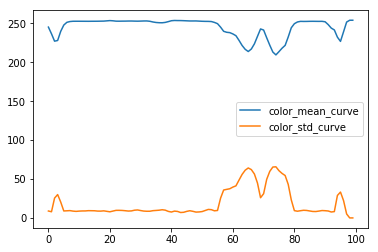

In [6]:
level = 6

origin_size = origin_slide.dimensions
origin_widths = origin_size[0]
origin_heights = origin_size[1]

object_size = origin_slide.level_dimensions[level]
object_widths = int(object_size[0])
object_heights = object_size[1]

color_aver = []
effec_num = []
color_std = []

for i in range(100):
    slide = origin_slide.read_region((0, i*origin_heights//100), level, (object_widths, object_heights//50))     # 循环顺序读取50高的区域
    img = slide.convert("L")      # 转为灰度图
    img1 = array(img)             # 转为像素矩阵
    color_aver.append(img1.mean())        # 将矩阵的像素值平均数作为数组记录下来
    color_std.append(img1.std())          # 将矩阵的像素值标准差作为数组记录下来
    # plt.imshow(img1)
    # plt.show()
    # if img1.mean()<225:
    #     effec_num.append(i)           # 判断矩阵的像素值平均数是否小于某个阈值，如果是，则表示找到了感兴趣区域
    if img1.std()>34:
        effec_num.append(i)            # 判断矩阵的像素值标准差是否大于某个阈值，如果是，则表示找到了感兴趣区域

print(np.transpose(effec_num))

effective_y = effec_num[0]*origin_heights//100        #有效区域的左上顶点y坐标找到了
print(effective_y,effec_num[-1])
effective_heights = (effec_num[-1]-effec_num[0]+2)*origin_heights//100 + origin_heights//50        #有效区域的高度也出来了
print(effective_heights)

plt.plot(range(100), color_aver[:100], label='color_mean_curve')
plt.plot(range(100), color_std[:100], label='color_std_curve')
plt.legend()
plt.show()

[  40.13359939   31.15761796   12.11816453    8.66173808    7.11521702
    3.29982807    1.67144755    1.93731273    3.28859015    5.12890509
    6.79982165    7.2925529     0.28600251    3.69975681    6.002182
    6.75409163    7.24377832    8.05387508   14.88693436   34.92139843
   51.32893049   57.08227296   61.34088319   65.91454739   65.23017049
   64.68524909   65.12127278   59.66894499   54.54222399   54.29164785
   53.7129731    54.29487115   58.06366739   62.03015536   65.72304334
   67.37200484   67.87985224   68.75126589   67.91570173   69.42204261
   73.71909239   72.74317323   69.64201918   69.30667829   68.07088451
   68.77178386   68.98146946   65.14975332   61.99224868   59.12390348
   56.22158711   59.55361626   67.16907341   71.21882848   73.32109786
   73.67734041   69.76511841   62.81656426   51.15528914   30.89688066
   11.39334474    7.19776825    6.34938274    6.34457252    6.06806227
    5.20650479    3.53646559    1.28830166    0.            0.            0.
  

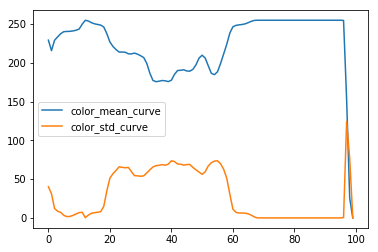

In [10]:
color_aver1 = []
effec_num_j = []
color_std1 = []

for j in range(100):
    slide2 = origin_slide.read_region((j*origin_widths//100, effective_y), level, (object_widths//50, effective_heights//62))     # 循环顺序读取50宽的区域
    src_img = slide2.convert("L")      # 转为灰度图
    src_img1 = array(src_img)             # 转为像素矩阵
    # color_mean['a']=int(img1.mean())
    # a = round(img1.mean())
    color_aver1.append(src_img1.mean())        # 将矩阵的像素值平均数作为数组记录下来
    color_std1.append(src_img1.std())          # 将矩阵的像素值标准差作为数组记录下来
    # plt.imshow(img1)
    # plt.show()
    # if img1.mean()<225:
    #     effec_num.append(i)           # 判断矩阵的像素值平均数是否小于某个阈值，如果是，则表示找到了感兴趣区域
    if src_img1.std()>41:
        effec_num_j.append(j)            # 判断矩阵的像素值标准差是否大于某个阈值，如果是，则表示找到了感兴趣区域
    # plt.imshow(src_img)
    # plt.show()

print(np.transpose(color_std1))
print(np.transpose(color_aver1))
print(np.transpose(effec_num_j))

effective_x = effec_num_j[0]*origin_widths//100        # 有效区域的左上顶点y坐标找到了
print("有效区域顶点的x值", effective_x)
effective_widths = (effec_num[-3]-effec_num[0]+10)*origin_widths//100 + origin_widths//50        # 有效区域的高度也出来了
print("有效区域的高度", effective_widths)

plt.plot(range(100), color_aver1[:100], label='color_mean_curve')
# plt.legend()
# plt.show()
plt.plot(range(100), color_std1[:100], label='color_std_curve')
plt.legend()
plt.show()

In [12]:
# 有效区域（感兴趣区域）
effective_area = (effective_x, effective_y)
effective_area_size = (effective_widths, effective_heights)
effective_area,effective_area_size

((19558, 125199), (30314, 54911))

这个有效区域，经过手动调试，起点坐标：(17600,124700) ，区域长宽：(44800,57600)



### mask 的有效区域，定位比较容易

In [27]:
from pylab import *
import numpy as np
mask_level = 7

# level0　的尺寸
mask_size = mask_slide.dimensions
mask_widths = mask_size[0]
mask_heights = mask_size[1]
# level7 的尺寸
mask_level_size = mask_slide.level_dimensions[mask_level]
mask_level_widths = mask_level_size[0]
mask_level_heights = mask_level_size[1]

mask_level_slide = mask_slide.read_region((0, 0), mask_level, (mask_level_widths, mask_level_heights))
mask_level_slide_gray = mask_level_slide.convert("L")
mask_level_slide_arr = array(mask_level_slide_gray)

mask_y, mask_x = nonzero(mask_level_slide_arr)
mask_x, mask_y

(array([457, 456, 457, 458, 456, 457, 458, 459, 456, 457, 458, 457, 458,
        456, 457, 454, 455, 456, 457, 458, 452, 453, 454, 455, 456, 457,
        458, 452, 453, 454, 455, 456, 457, 458, 459, 451, 452, 453, 454,
        455, 456, 457, 458, 459, 460, 451, 452, 453, 454, 455, 456, 457,
        458, 459, 463, 464, 452, 453, 454, 455, 456, 457, 458, 459, 462,
        463, 464, 452, 453, 454, 455, 456, 457, 458, 459, 460, 452, 453,
        454, 455, 456, 457, 458, 459, 460, 461, 462, 452, 453, 454, 455,
        456, 457, 458, 459, 460, 461, 462, 456, 457, 458, 459, 457, 458,
        459, 458, 459, 460, 464, 465, 459, 460, 463, 464, 459, 460, 459,
        460, 461, 458, 459, 460, 461, 457, 458, 459, 460, 461, 456, 457,
        458, 459, 460, 456, 457, 458, 459, 460, 461, 462, 458, 459, 460,
        461, 462, 459, 460]),
 array([1066, 1067, 1067, 1067, 1068, 1068, 1068, 1068, 1069, 1069, 1069,
        1070, 1070, 1072, 1072, 1073, 1073, 1073, 1073, 1073, 1074, 1074,
        1074, 1074,

In [56]:
# 有效区域（感兴趣区域）
mask_effective_leftup_point = (min(mask_x), min(mask_y))
mask_effective_rightdown_point = (max(mask_x), max(mask_y))

mask_effective_leftup_point,mask_effective_rightdown_point

((451, 1066), (465, 1093))

In [51]:
mask_tumor_start = ((min(mask_x)-1) * int(mask_slide.level_downsamples[7]), 
                    (min(mask_y)-1) * int(mask_slide.level_downsamples[7]))
mask_tumor_end = (max(mask_x) * int(mask_slide.level_downsamples[7]), 
                  max(mask_y) * int(mask_slide.level_downsamples[7]))

mask_tumor_start, mask_tumor_end    # mask 图中tumor所在区域的起点和终点

((57600, 136320), (59520, 139904))

In [54]:
mask_tumor_area = ((max(mask_x)-min(mask_x)+2)*int(mask_slide.level_downsamples[7]), 
                   (max(mask_y)-min(mask_y)+2)*int(mask_slide.level_downsamples[7]))
mask_tumor_area        # mask区域的长宽

(2048, 3712)

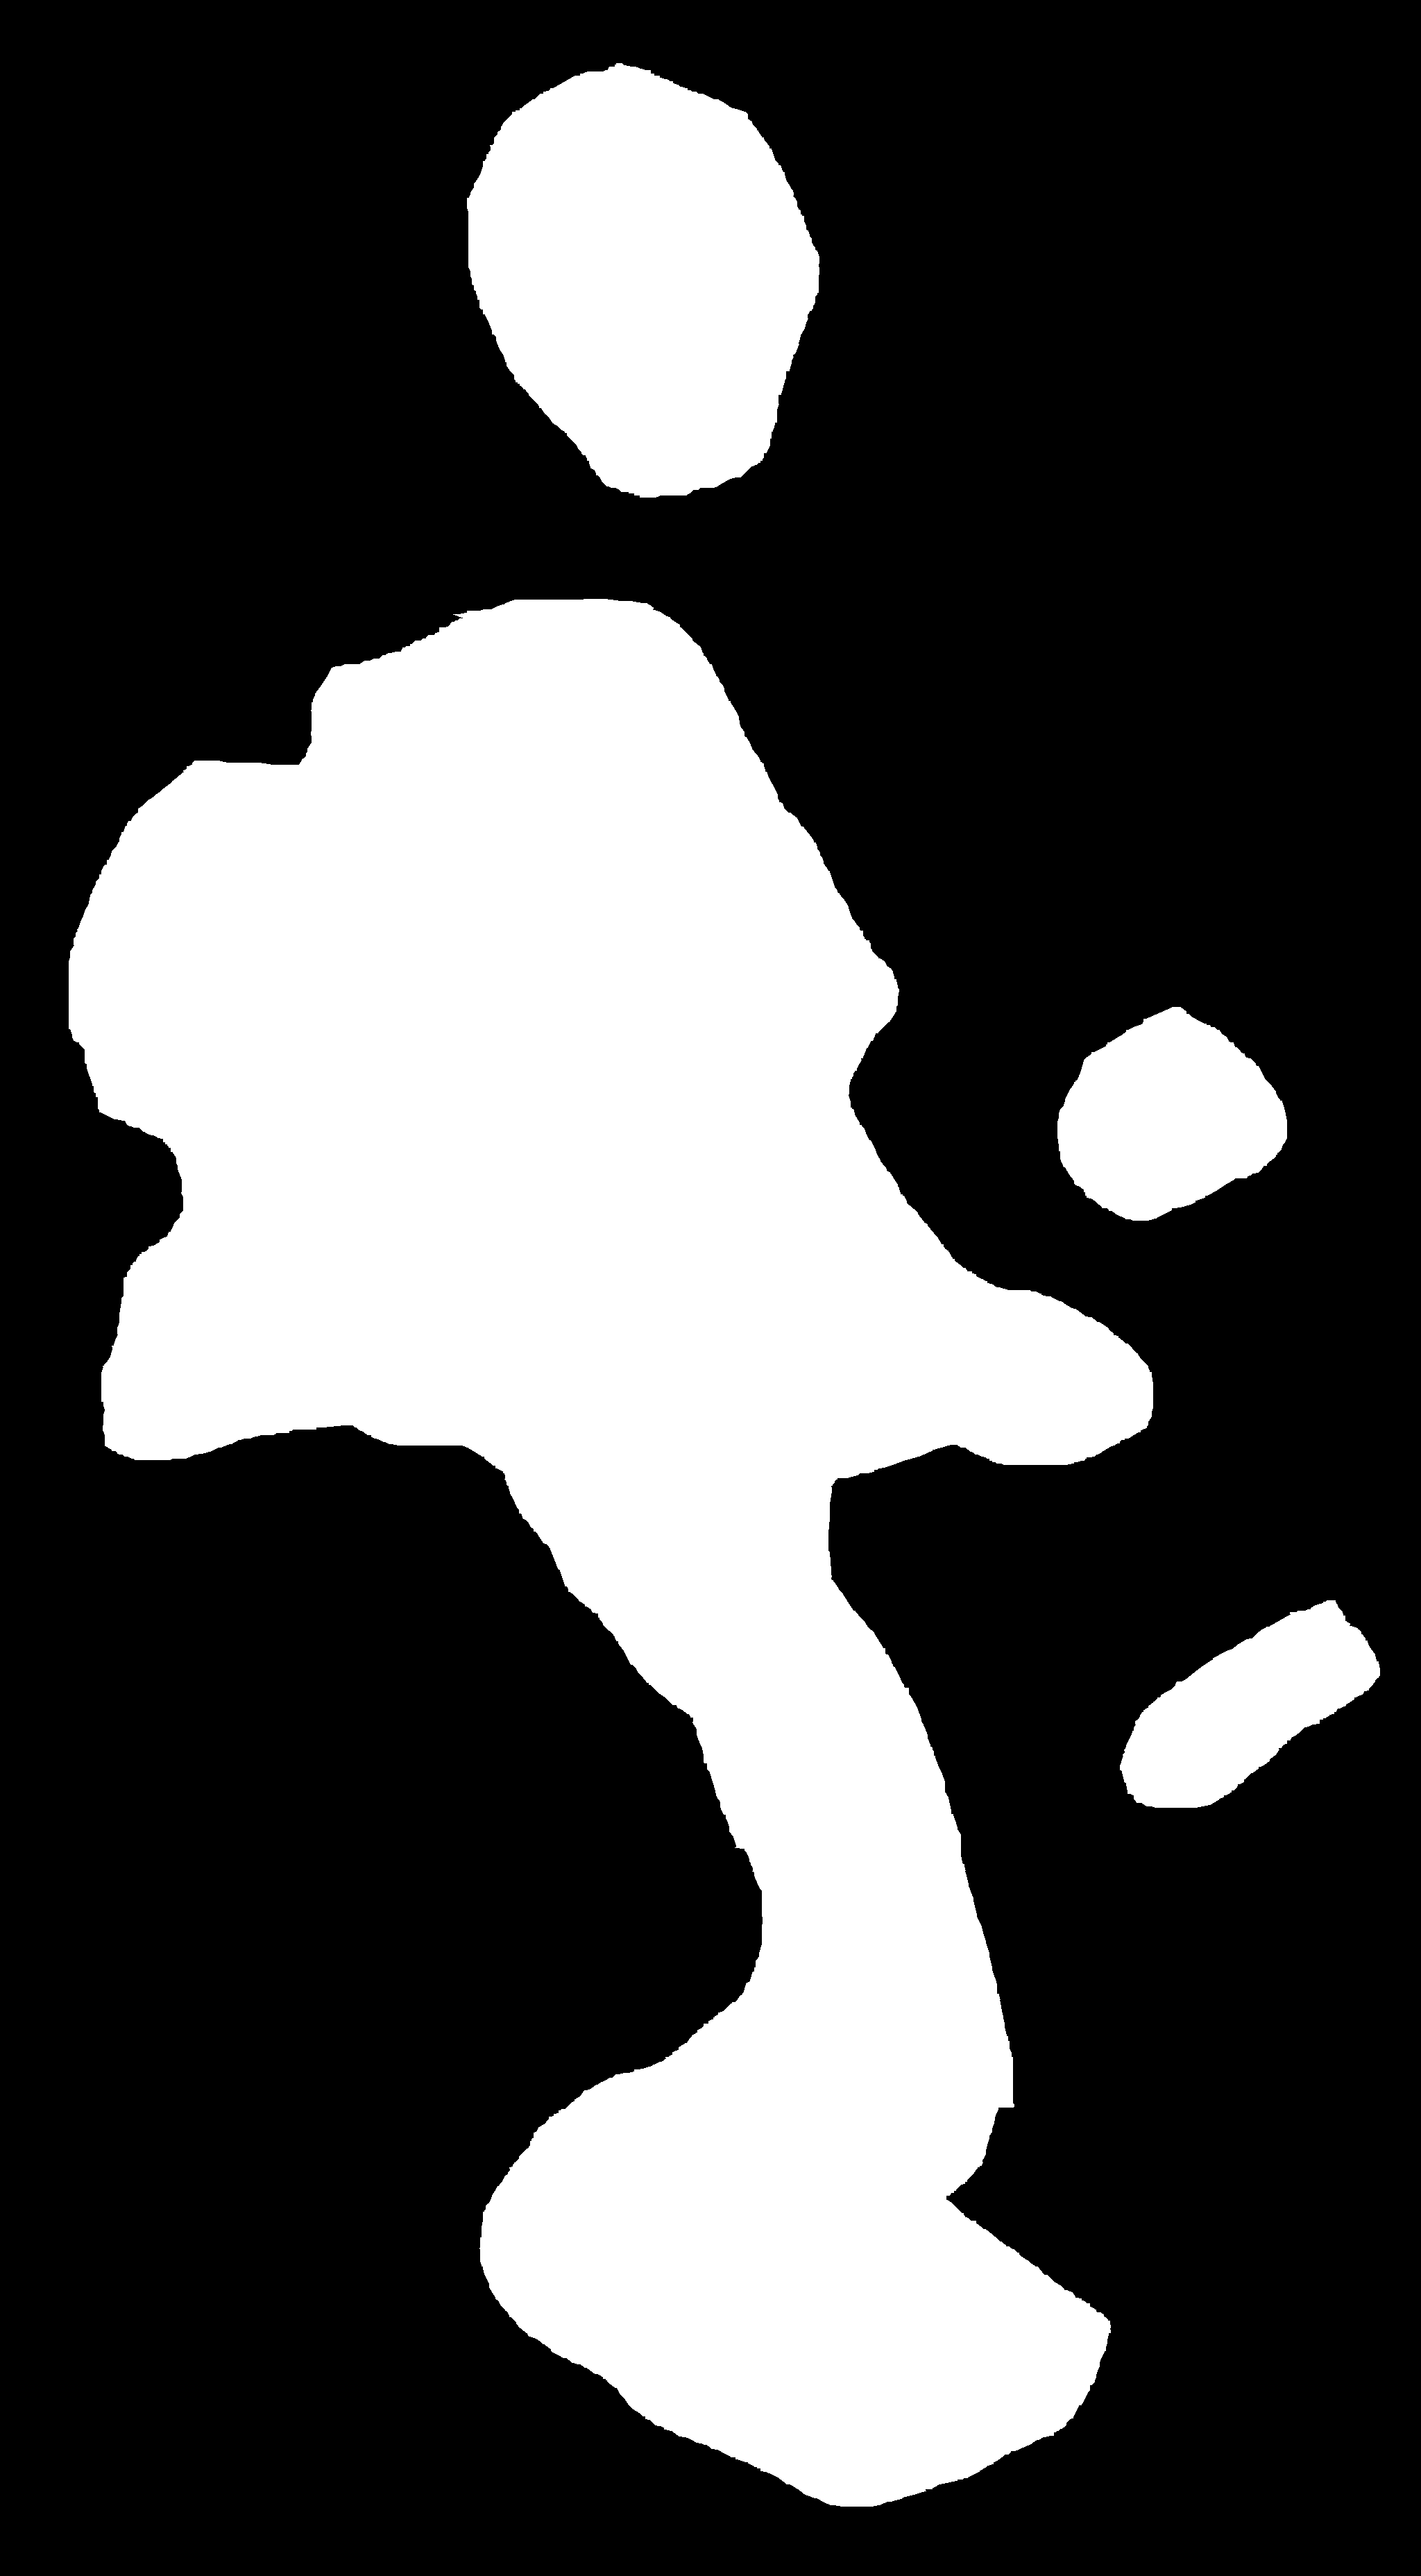

In [58]:
mask_slide.read_region(mask_tumor_start, 0, mask_tumor_area) 
# mask_tumor_start 和　mask_tumor_area 这两个参数后面要用到

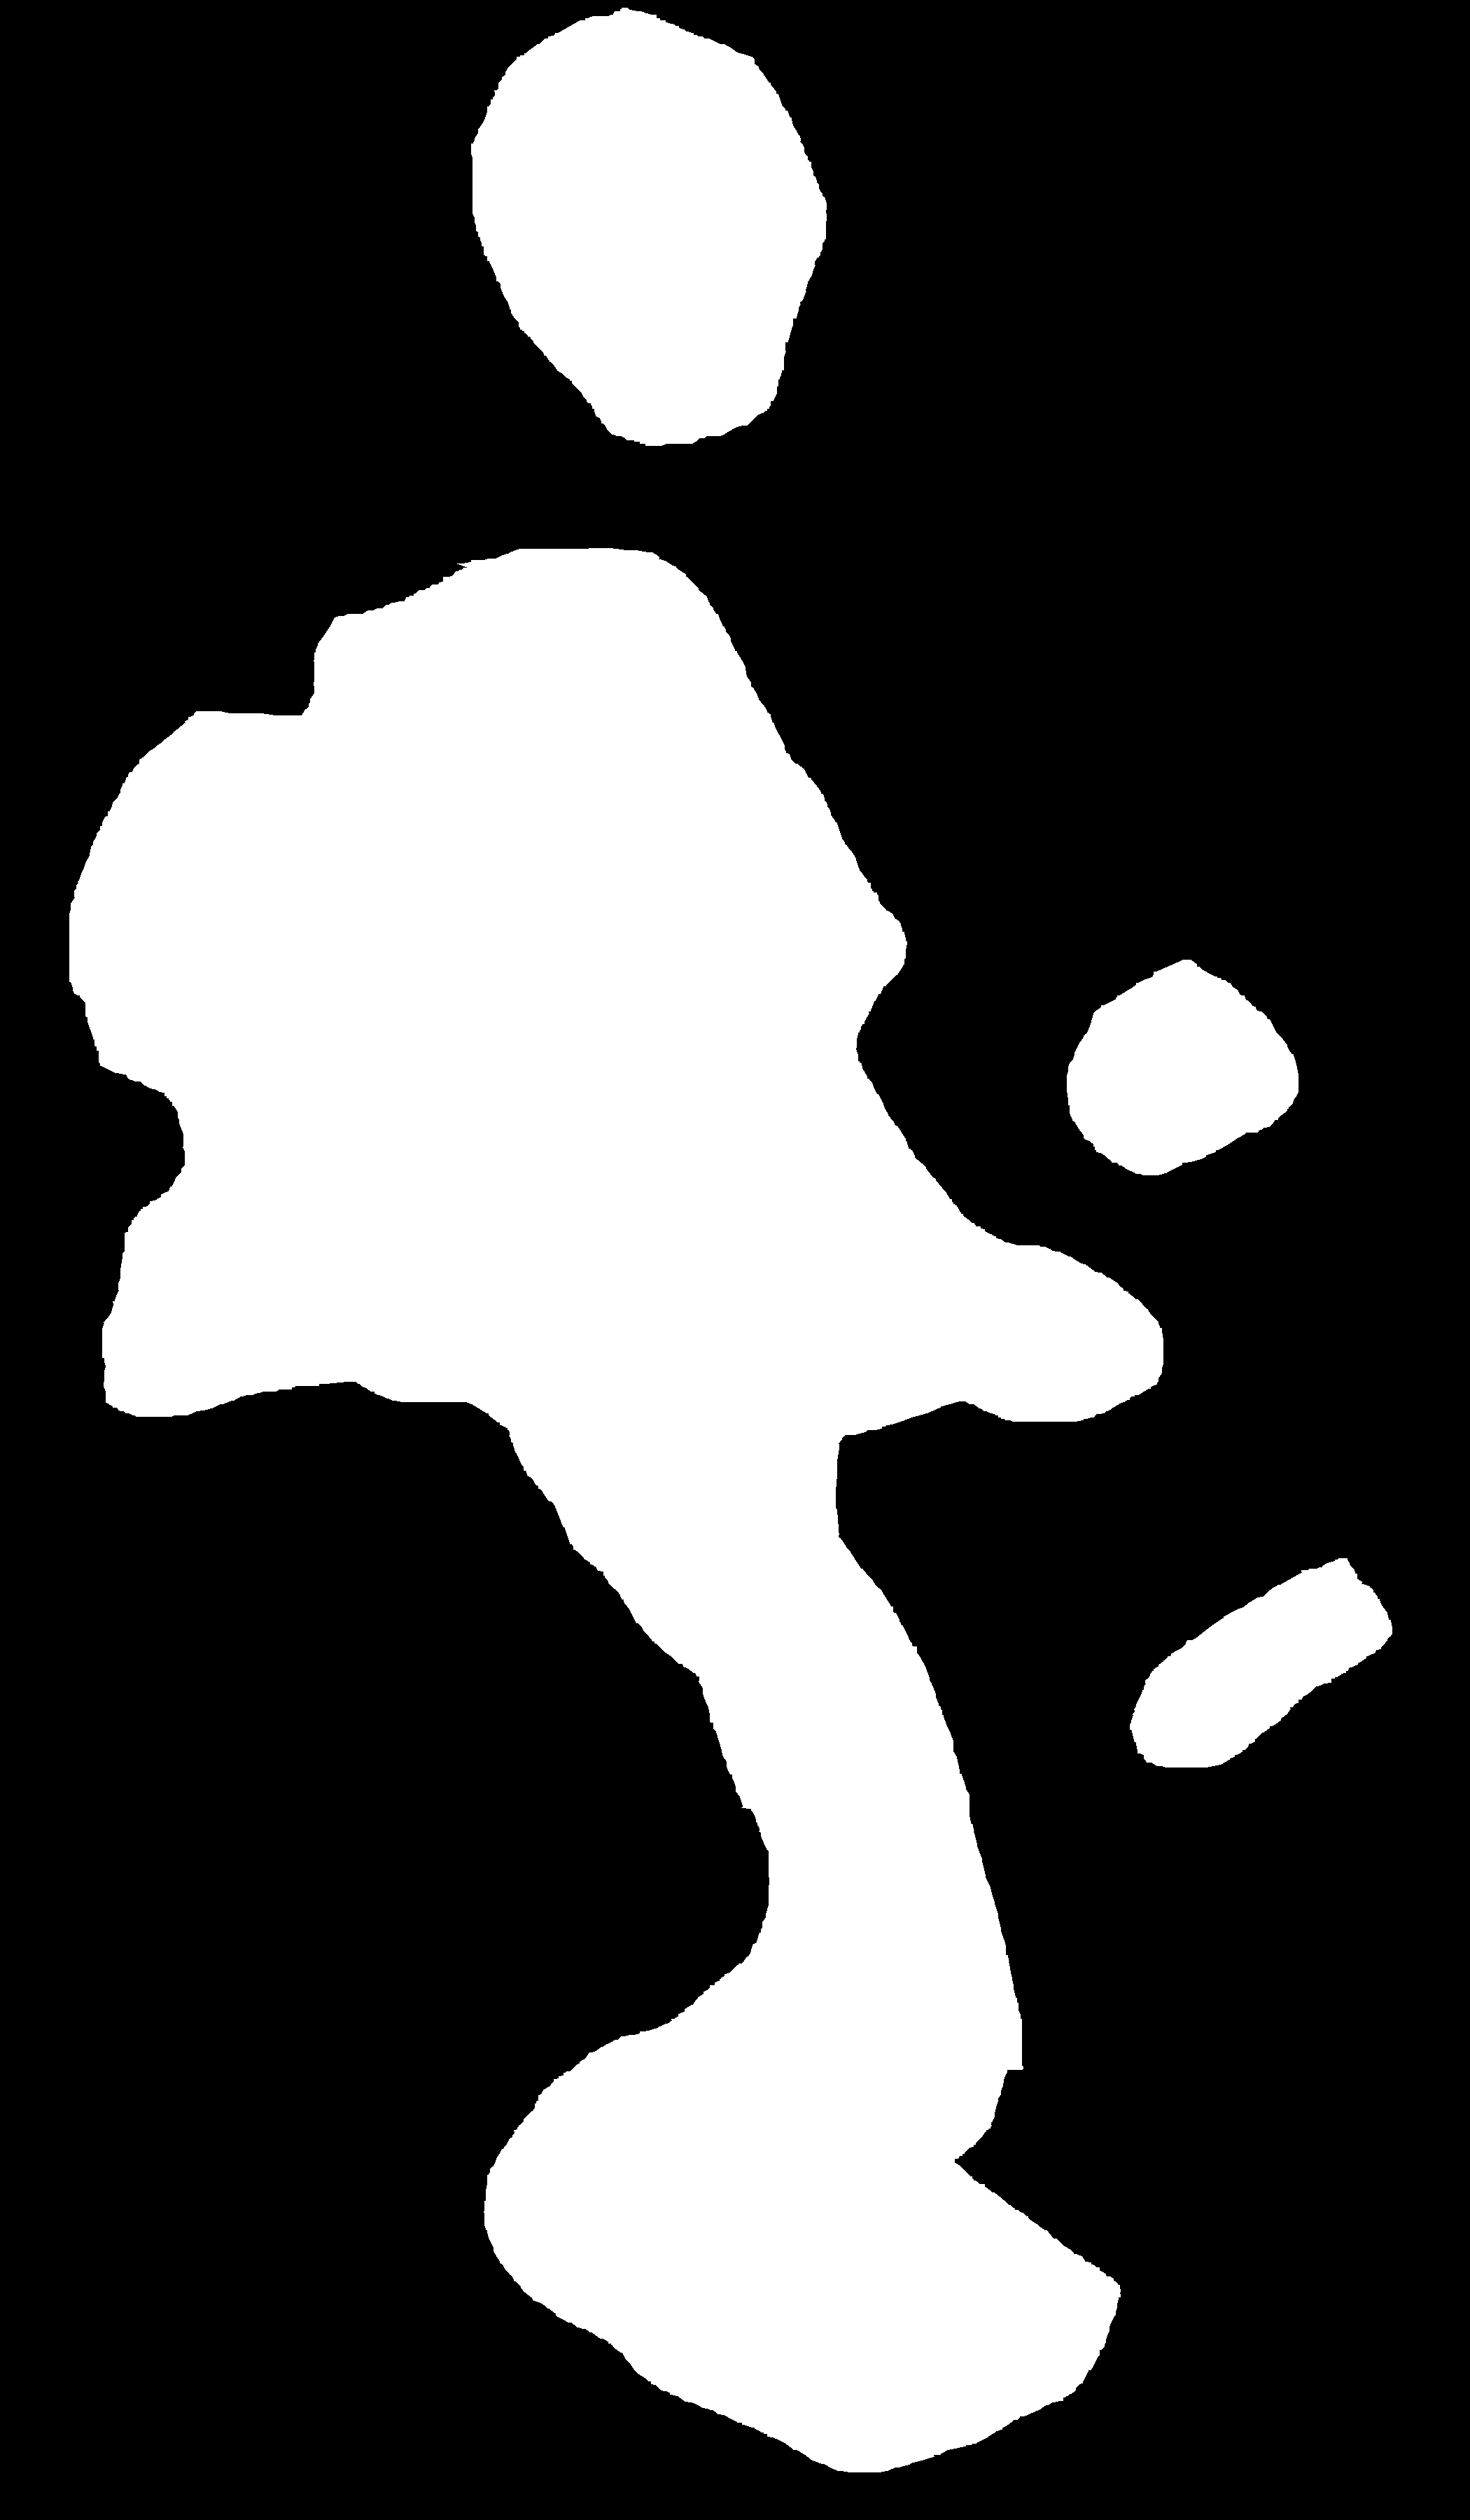

In [60]:
# 这是手动调出来的结果，可以做对比
location=(57600,136400)
level = 0
size = (2100,3600)
mask_slide.read_region(location, level, size)

39030 167139


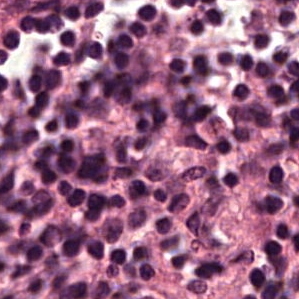

In [81]:
# 修改算法，第一次：人为给定区域

import numpy as np
from PIL.Image import Image
from pylab import *

widths = 299
heights = 299

# 有效区域（感兴趣区域）
effective_area = (effective_x, effective_y)
effective_area_size = (effective_widths, effective_heights)

# mask_slide.read_region(mask_tumor_start, 0, mask_tumor_area) 

# 定义随机坐标

random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
print(random_x,random_y)
random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))  #注意 openslide 的读取方式
# random_img

random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
random_img_mask_gray = random_img_mask.convert("L")
random_img_mask_arr = array(random_img_mask_gray)

while(True):
    if not random_img_mask_arr:
        y = 1
        random_img 是训练数据
        break
    else:
        random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
        random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
        print(random_x,random_y)
        random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))  #注意 openslide 的读取方式
    #     random_img

        random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
        random_img_mask_gray = random_img_mask.convert("L")
        random_img_mask_arr = array(random_img_mask_gray)

可以看出随机读取的图片，有空白图，这是代码需要改进的地方。

In [12]:
import numpy as np
def categorical(y, num_classes=None):
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    return categorical